均衡点:
x: 0, y: 0
x: 0, y: 1
x: 0, y: (-C + F)/(B + F)
x: 1, y: 0
x: 1, y: 1
x: 1, y: (-C + F)/(B + F)
x: (P0 - P1)/(B + F), y: 0
x: (P0 - P1)/(B + F), y: 1
x: (P0 - P1)/(B + F), y: (-C + F)/(B + F)

均衡点 x: 0, y: 0 的雅可比矩阵特征值:
特征值: 50, 实部: 50
此均衡点是不稳定的

均衡点 x: 0, y: 1 的雅可比矩阵特征值:
特征值: 50, 实部: 50
此均衡点是不稳定的

均衡点 x: 0, y: (-C + F)/(B + F) 的雅可比矩阵特征值:
特征值: 50, 实部: 50
此均衡点是不稳定的

均衡点 x: 1, y: 0 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: 20, 实部: 20
此均衡点是不稳定的

均衡点 x: 1, y: 1 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: 30, 实部: 30
此均衡点是不稳定的

均衡点 x: 1, y: (-C + F)/(B + F) 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: -12, 实部: -12
此均衡点是稳定的

均衡点 x: (P0 - P1)/(B + F), y: 0 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: 20, 实部: 20
此均衡点是不稳定的

均衡点 x: (P0 - P1)/(B + F), y: 1 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: 30, 实部: 30
此均衡点是不稳定的

均衡点 x: (P0 - P1)/(B + F), y: (-C + F)/(B + F) 的雅可比矩阵特征值:
特征值: -100, 实部: -100
特征值: -12, 实部: -12
此均衡点是稳定的


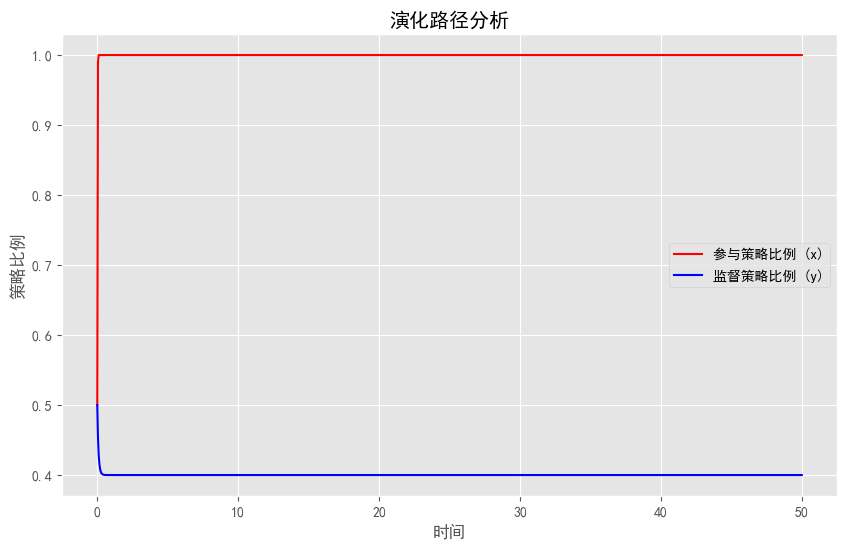

In [1]:
import numpy as np
from scipy.integrate import odeint
import sympy as sp
import matplotlib.pyplot as plt

# 定义符号变量
x, y = sp.symbols('x y')
V, C, B, F, P1, P0 = sp.symbols('V C B F P1 P0')

# 定义参数值（可以根据需要调整）
params = {V: 100, C: 10, B: 20, F: 30, P1: 50, P0: 0}

# 1. 复制动态方程构建
# 企业参与策略的平均收益
avg_U_firm_participate = x * (P1 + B) + (1 - x) * P1
avg_U_firm_not_participate = x * (P0 - F) + (1 - x) * P0
phi_x = x * (avg_U_firm_participate - (x * avg_U_firm_participate + (1 - x) * avg_U_firm_not_participate))

# 政府监督策略的平均收益
avg_U_gov_supervise = y * (V - C - B) + (1 - y) * (F - C)
avg_U_gov_no_supervise = y * V + (1 - y) * 0
phi_y = y * (avg_U_gov_supervise - (y * avg_U_gov_supervise + (1 - y) * avg_U_gov_no_supervise))

# 2. 求解均衡点
equilibrium_x = sp.solve(phi_x, x)
equilibrium_y = sp.solve(phi_y, y)

# 筛选出 [x, y] 均衡点对
equilibrium_points = [(x_val, y_val) for x_val in equilibrium_x for y_val in equilibrium_y]

print('均衡点:')
for point in equilibrium_points:
    print(f'x: {point[0]}, y: {point[1]}')

# 3. 稳定性分析 - 计算雅可比矩阵并求特征值
# 定义复制动态方程的向量
phi = sp.Matrix([phi_x, phi_y])
variables = sp.Matrix([x, y])

# 计算雅可比矩阵
J = phi.jacobian(variables)

# 检查每个均衡点的稳定性
for point in equilibrium_points:
    J_at_point = J.subs([(x, point[0]), (y, point[1])] + list(params.items()))
    eigenvalues = J_at_point.eigenvals()

    print(f'\n均衡点 x: {point[0]}, y: {point[1]} 的雅可比矩阵特征值:')
    for eig in eigenvalues:
        print(f'特征值: {eig}, 实部: {sp.re(eig)}')

        if sp.re(eig) > 0:
            print('此均衡点是不稳定的')
            break
    else:
        print('此均衡点是稳定的')

# 4. 演化路径分析
# 转换复制动态方程为数值函数
phi_x_func = sp.lambdify((x, V, C, B, F, P1, P0), phi_x.subs(params), 'numpy')
phi_y_func = sp.lambdify((y, V, C, B, F, P1, P0), phi_y.subs(params), 'numpy')

# 定义微分方程组
def replicator_dynamics(X, t, params_values):
    x, y = X
    dxdt = phi_x_func(x, *params_values.values())
    dydt = phi_y_func(y, *params_values.values())
    return [dxdt, dydt]

# 设置初始条件和时间范围
initial_conditions = [0.5, 0.5]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()
